## Exercise Overview
In this exercise we will play with Spark [Datasets & Dataframes](https://spark.apache.org/docs/latest/sql-programming-guide.html#datasets-and-dataframes), some [Spark SQL](https://spark.apache.org/docs/latest/sql-programming-guide.html#sql), and build a couple of binary classifiaction models using [Spark ML](https://spark.apache.org/docs/latest/ml-guide.html) (with some [MLlib](https://spark.apache.org/mllib/) too). 
<br><br>
The set up and approach will not be too dissimilar to the standard type of approach you might do in [Sklearn](http://scikit-learn.org/stable/index.html). Spark has matured to the stage now where for 90% of what you need to do (when analysing tabular data) should be possible with Spark dataframes, SQL, and ML libraries. This is where this exercise is mainly trying to focus.  
<br>
Feel free to adapt this exercise to play with other datasets readily availabe in the Databricks enviornment (they are listed in a cell below). 

##### Getting Started
To get started you will need to create and attach a databricks spark cluster to this notebook. This notebook was developed on a cluster created with: 
- Databricks Runtime Version 4.0 (includes Apache Spark 2.3.0, Scala 2.11)
- Python Version 3

##### Links & References

Some useful links and references of sources used in creating this exercise:

**Note**: Right click and open as new tab!
<br>
1. [Latest Spark Docs](https://spark.apache.org/docs/latest/index.html)
1. [Databricks Homepage](https://databricks.com/)
1. [Databricks Community Edition FAQ](https://databricks.com/product/faq/community-edition)
1. [Databricks Self Paced Training](https://databricks.com/training-overview/training-self-paced)
1. [Databricks Notebook Guide](https://docs.databricks.com/user-guide/notebooks/index.html)
1. [Databricks Binary Classification Tutorial](https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html#binary-classification)

#### Get Data

Here we will pull in some sample data that is already pre-loaded onto all databricks clusters.

Feel free to adapt this notebook later to play around with a different dataset if you like (all available are listed in a cell below).

In [ ]:
## display datasets already in databricks
# display(dbutils.fs.ls("/databricks-datasets"))

Lets take a look at the '**adult**' dataset on the filesystem. This is the typical US Census data you often see online in tutorials. [Here](https://archive.ics.uci.edu/ml/datasets/adult) is the same data in the UCI repository.

_As an aside: [here](https://github.com/GoogleCloudPlatform/cloudml-samples/tree/master/census) this same dataset is used as a quickstart example for Google CLoud ML & Tensorflow Estimator API (in case youd be interested in playing with tensorflow on the same dataset as here)._

In [ ]:
# %fs ls databricks-datasets/adult/adult.data

**Note**: Above  %fs is just some file system cell magic that is specific to databricks. More info [here](https://docs.databricks.com/user-guide/notebooks/index.html#mix-languages).

#### Spark SQL

Below we will use Spark SQL to load in the data and then register it as a Dataframe aswell. So the end result will be a Spark SQL table called _adult_ and a Spark Dataframe called _df_adult_. 
<br><br>
This is an example of the flexibility in Spark in that you could do lots of you ETL and data wrangling using either Spark SQL or Dataframes and pyspark. Most of the time it's a case of using whatever you are most comfortable with.
<br><br>
When you get more advanced then you might looking the pro's and con's of each and when you might favour one or the other (or operating direclty on RDD's), [here](https://databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html) is a good article on the issues. For now, no need to overthink it!

In [1]:
import pyspark

In [2]:
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sqlContext = pyspark.sql.SQLContext(spark)

In [3]:
schema = pyspark.sql.types.StructType([
    pyspark.sql.types.StructField("age", pyspark.sql.types.DoubleType(), True),
    pyspark.sql.types.StructField("workclass", pyspark.sql.types.StringType(), True),
    pyspark.sql.types.StructField("fnlwgt", pyspark.sql.types.DoubleType(), True),
    pyspark.sql.types.StructField("education", pyspark.sql.types.StringType(), True),
    pyspark.sql.types.StructField("education_num", pyspark.sql.types.DoubleType(), True),
    pyspark.sql.types.StructField("marital_status", pyspark.sql.types.StringType(), True),
    pyspark.sql.types.StructField("occupation", pyspark.sql.types.StringType(), True),
    pyspark.sql.types.StructField("relationship", pyspark.sql.types.StringType(), True),
    pyspark.sql.types.StructField("race", pyspark.sql.types.StringType(), True),
    pyspark.sql.types.StructField("sex", pyspark.sql.types.StringType(), True),
    pyspark.sql.types.StructField("capital_gain", pyspark.sql.types.DoubleType(), True),
    pyspark.sql.types.StructField("capital_loss", pyspark.sql.types.DoubleType(), True),
    pyspark.sql.types.StructField("hours_per_week", pyspark.sql.types.DoubleType(), True),
    pyspark.sql.types.StructField("native_country", pyspark.sql.types.StringType(), True),
    pyspark.sql.types.StructField("income", pyspark.sql.types.StringType(), True),
])

In [4]:
df = spark.read.csv('adult.csv', schema=schema, header=True)

In [5]:
df.show(2)

+---+----------------+-------+---------+-------------+------------------+---------------+-------------+-----+----+------------+------------+--------------+--------------+------+
|age|       workclass| fnlwgt|education|education_num|    marital_status|     occupation| relationship| race| sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+----------------+-------+---------+-------------+------------------+---------------+-------------+-----+----+------------+------------+--------------+--------------+------+
|2.0|       State-gov|77516.0|Bachelors|         13.0|     Never-married|   Adm-clerical|Not-in-family|White|Male|         1.0|         0.0|           2.0| United-States| <=50K|
|3.0|Self-emp-not-inc|83311.0|Bachelors|         13.0|Married-civ-spouse|Exec-managerial|      Husband|White|Male|         0.0|         0.0|           0.0| United-States| <=50K|
+---+----------------+-------+---------+-------------+------------------+---------------+-------------+-----+-

In [6]:
df.createOrReplaceTempView("adult")

In [7]:
spark.sql("SELECT * FROM adult LIMIT 5").show()

+---+----------------+--------+---------+-------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|age|       workclass|  fnlwgt|education|education_num|    marital_status|       occupation| relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+----------------+--------+---------+-------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|2.0|       State-gov| 77516.0|Bachelors|         13.0|     Never-married|     Adm-clerical|Not-in-family|White|  Male|         1.0|         0.0|           2.0| United-States| <=50K|
|3.0|Self-emp-not-inc| 83311.0|Bachelors|         13.0|Married-civ-spouse|  Exec-managerial|      Husband|White|  Male|         0.0|         0.0|           0.0| United-States| <=50K|
|2.0|         Private|215646.0|  HS-grad|          9.0|          Divorced|Handlers-cl

If you are more comfortable with SQL then as you can see below, its very easy to just get going with writing standard SQL type code to analyse your data, do data wrangling and create new dataframes.

In [8]:
# Lets get some summary marital status rates by occupation
result = spark.sql(
  """
  SELECT 
    occupation,
    SUM(1) as n,
    ROUND(AVG(if(LTRIM(marital_status) LIKE 'Married-%',1,0)),2) as married_rate,
    ROUND(AVG(if(lower(marital_status) LIKE '%widow%',1,0)),2) as widow_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Divorced',1,0)),2) as divorce_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Separated',1,0)),2) as separated_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Never-married',1,0)),2) as bachelor_rate
  FROM 
    adult 
  GROUP BY 1
  ORDER BY n DESC
  """)
#display(result)
result.show()

+-----------------+----+------------+----------+------------+--------------+-------------+
|       occupation|   n|married_rate|widow_rate|divorce_rate|separated_rate|bachelor_rate|
+-----------------+----+------------+----------+------------+--------------+-------------+
|   Prof-specialty|6172|        0.53|      0.02|        0.13|          0.02|          0.3|
|     Craft-repair|6112|        0.64|      0.01|        0.11|          0.03|         0.21|
|  Exec-managerial|6086|         0.6|      0.03|        0.15|          0.02|         0.21|
|     Adm-clerical|5611|        0.28|      0.04|        0.21|          0.04|         0.42|
|            Sales|5504|        0.46|      0.03|        0.12|          0.03|         0.36|
|    Other-service|4923|        0.24|      0.05|        0.15|          0.06|          0.5|
|Machine-op-inspct|3022|         0.5|      0.03|        0.14|          0.04|         0.29|
|             null|2809|        0.35|      0.08|         0.1|          0.03|         0.44|

You can easily register dataframes as a table for Spark SQL too. So this way you can easily move between Dataframes and Spark SQL for whatever reason.

In [9]:
# register the df we just made as a table for spark sql
sqlContext.registerDataFrameAsTable(result, "result")
spark.sql("SELECT * FROM result").show(5)

+---------------+----+------------+----------+------------+--------------+-------------+
|     occupation|   n|married_rate|widow_rate|divorce_rate|separated_rate|bachelor_rate|
+---------------+----+------------+----------+------------+--------------+-------------+
| Prof-specialty|6172|        0.53|      0.02|        0.13|          0.02|          0.3|
|   Craft-repair|6112|        0.64|      0.01|        0.11|          0.03|         0.21|
|Exec-managerial|6086|         0.6|      0.03|        0.15|          0.02|         0.21|
|   Adm-clerical|5611|        0.28|      0.04|        0.21|          0.04|         0.42|
|          Sales|5504|        0.46|      0.03|        0.12|          0.03|         0.36|
+---------------+----+------------+----------+------------+--------------+-------------+
only showing top 5 rows



#### <span style="color:darkblue">Question 1</span>

1. Write some spark sql to get the top 'bachelor_rate' by 'education' group?

In [10]:
### Question 1.1 Answer ###
result = spark.sql(
  """
  SELECT 
    FIRST(education) as education,
    ROUND(AVG(if(LTRIM(marital_status) = 'Never-married',1,0)),2) as bachelor_rate
  FROM 
    adult 
  GROUP BY education_num
  ORDER BY education_num
  """)
result.show()

+------------+-------------+
|   education|bachelor_rate|
+------------+-------------+
|   Preschool|         0.46|
|     1st-4th|          0.2|
|     5th-6th|         0.25|
|     7th-8th|         0.17|
|         9th|         0.29|
|        10th|         0.38|
|        11th|          0.5|
|        12th|         0.53|
|     HS-grad|          0.3|
|Some-college|         0.41|
|   Assoc-voc|         0.26|
|  Assoc-acdm|         0.33|
|   Bachelors|         0.33|
|     Masters|         0.24|
| Prof-school|         0.17|
|   Doctorate|         0.16|
+------------+-------------+



#### Spark DataFrames

Below we will create our DataFrame from the SQL table and do some similar analysis as we did with Spark SQL but using the DataFrames API.

In [11]:
# register a df from the sql df
df_adult = spark.table("adult")
cols = df_adult.columns # this will be used much later in the notebook, ignore for now

In [12]:
# look at df schema
df_adult.printSchema()

root
 |-- age: double (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



In [13]:
# look at the df
#display(df_adult)
df_adult.show(5)

+---+----------------+--------+---------+-------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|age|       workclass|  fnlwgt|education|education_num|    marital_status|       occupation| relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+----------------+--------+---------+-------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|2.0|       State-gov| 77516.0|Bachelors|         13.0|     Never-married|     Adm-clerical|Not-in-family|White|  Male|         1.0|         0.0|           2.0| United-States| <=50K|
|3.0|Self-emp-not-inc| 83311.0|Bachelors|         13.0|Married-civ-spouse|  Exec-managerial|      Husband|White|  Male|         0.0|         0.0|           0.0| United-States| <=50K|
|2.0|         Private|215646.0|  HS-grad|          9.0|          Divorced|Handlers-cl

Below we will do a similar calculation to what we did above but using the DataFrames API

In [14]:
# import what we will need
#from pyspark.sql.functions import when, col, mean, desc, round
import pyspark.sql.functions as sqlfunc

In [16]:
# wrangle the data a bit
df_result = df_adult.select(
  df_adult['occupation'], 
  # create a 1/0 type col on the fly
  sqlfunc.when( sqlfunc.col('marital_status') == 'Divorced' , 1 ).otherwise(0).alias('is_divorced')
)
# do grouping (and a round)
df_result = df_result.groupBy('occupation').agg(sqlfunc.round(sqlfunc.mean('is_divorced'),2).alias('divorced_rate'))
# do ordering
df_result = df_result.orderBy(sqlfunc.desc('divorced_rate'))
# show results
df_result.show()

+-----------------+-------------+
|       occupation|divorced_rate|
+-----------------+-------------+
|     Adm-clerical|         0.21|
|  Priv-house-serv|         0.19|
|     Tech-support|         0.17|
|  Exec-managerial|         0.15|
|    Other-service|         0.15|
|Machine-op-inspct|         0.14|
|   Prof-specialty|         0.13|
|  Protective-serv|         0.12|
|            Sales|         0.12|
|     Craft-repair|         0.11|
| Transport-moving|         0.11|
|Handlers-cleaners|          0.1|
|             null|          0.1|
|  Farming-fishing|         0.06|
|     Armed-Forces|          0.0|
+-----------------+-------------+



As you can see the dataframes api is a bit more verbose then just expressing what you want to do in standard SQL.<br><br>But some prefer it and might be more used to it, and there could be cases where expressing what you need to do might just be better using the DataFrame API if it is too complicated for a simple SQL expression for example of maybe involves recursion of some type.

#### <span style="color:darkblue">Question 2</span>
1. Write some pyspark to get the top 'bachelor_rate' by 'education' group using DataFrame operations?

In [18]:
### Question 2.1 Answer ###

# wrangle the data a bit
df_result = df_adult.select(
  df_adult['education'], 
  # create a 1/0 type col on the fly
  sqlfunc.when( sqlfunc.col('marital_status') == 'Never-married' , 1 ).otherwise(0).alias('is_bachelor')
)
# do grouping (and a round)
df_result = df_result.groupBy('education').agg(sqlfunc.round(sqlfunc.mean('is_bachelor'),2).alias('bachelor_rate'))
# do ordering
df_result = df_result.orderBy(sqlfunc.desc('bachelor_rate'))
# show results
df_result.show(1)

+---------+-------------+
|education|bachelor_rate|
+---------+-------------+
|     12th|         0.53|
+---------+-------------+
only showing top 1 row



#### Explore & Visualize Data

It's very easy to [collect()](https://spark.apache.org/docs/latest/rdd-programming-guide.html#printing-elements-of-an-rdd) your Spark DataFrame data into a Pandas df and then continue to analyse or plot as you might normally.
<br><br>
Obviously if you try to collect() a huge DataFrame then you will run into issues, so usually you would only collect aggregated or sampled data into a Pandas df.

In [19]:
import pandas as pd

# do some analysis
result = spark.sql(
  """
  SELECT 
    occupation,
    AVG(IF(income = '>50K',1,0)) as plus_50k
  FROM 
    adult 
  GROUP BY 1
  ORDER BY 2 DESC
  """)

# collect results into a pandas df
df_pandas = pd.DataFrame(
  result.collect(),
  columns=result.schema.names
)

# look at df
print(df_pandas.head())

        occupation  plus_50k
0  Exec-managerial  0.477818
1   Prof-specialty  0.451069
2     Armed-Forces  0.333333
3  Protective-serv  0.313327
4     Tech-support  0.290456


In [20]:
print(df_pandas.describe())

        plus_50k
count  15.000000
mean    0.210358
std     0.143670
min     0.012397
25%     0.105224
50%     0.204246
75%     0.301891
max     0.477818


In [21]:
print(df_pandas.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   occupation  14 non-null     object 
 1   plus_50k    15 non-null     float64
dtypes: float64(1), object(1)
memory usage: 368.0+ bytes
None


Here we will just do some very basic plotting to show how you might collect what you are interested in into a Pandas DF and then just plot any way you normally would.

For simplicity we are going to use the plotting functionality built into pandas (you could make this a pretty as you want).

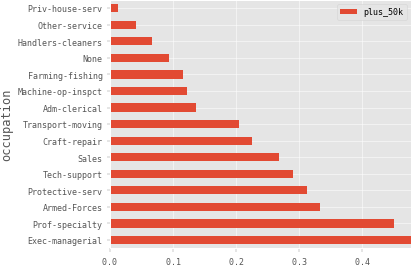

In [22]:
import matplotlib.pyplot as plt

# i like ggplot style
plt.style.use('ggplot')

# get simple plot on the pandas data
myplot = df_pandas.plot(kind='barh', x='occupation', y='plus_50k')

# display the plot (note - display() is a databricks function - 
# more info on plotting in Databricks is here: https://docs.databricks.com/user-guide/visualizations/matplotlib-and-ggplot.html)
#display(myplot.figure)

You can also easily get summary stats on a Spark DataFrame like below. [Here](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html) is a nice blog post that has more examples.<br><br>So this is an example of why you might want to move from Spark SQL into DataFrames API as being able to just call describe() on the Spark DF is easier then trying to do the equivilant in Spark SQL.

In [23]:
# describe df
df_adult.select(df_adult['age'],df_adult['education_num']).describe().show()

+-------+------------------+------------------+
|summary|               age|     education_num|
+-------+------------------+------------------+
|  count|             48842|             48842|
|   mean|1.7710781704270915|10.078088530363212|
| stddev|1.2953781873323977|2.5709727555922646|
|    min|               0.0|               1.0|
|    max|               4.0|              16.0|
+-------+------------------+------------------+



### ML Pipeline - Logistic Regression vs Random Forest

Below we will create two [Spark ML Pipelines](https://spark.apache.org/docs/latest/ml-pipeline.html) - one that fits a logistic regression and one that fits a random forest. We will then compare the performance of each.

**Note**: A lot of the code below is adapted from [this example](https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html).

In [32]:
from pyspark.ml import Pipeline
#from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder

categoricalColumns = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]
stages = [] # stages in our Pipeline

for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    stringIndexer.setHandleInvalid('skip')
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    # encoder = OneHotEncoderEstimator(inputCol=categoricalCol + "Index", outputCol=categoricalCol + "classVec")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

In [33]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="income", outputCol="label")
label_stringIdx.setHandleInvalid('skip')
stages += [label_stringIdx]

In [34]:
# Transform all features into a vector using VectorAssembler
numericCols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [35]:
# Create a Pipeline.
pipeline = Pipeline(stages=stages)
# Run the feature transformations.
#  - fit() computes feature statistics as needed.
#  - transform() actually transforms the features.
pipelineModel = pipeline.fit(df_adult)
dataset = pipelineModel.transform(df_adult)
# Keep relevant columns
selectedcols = ["label", "features"] + cols
dataset = dataset.select(selectedcols)
display(dataset)

DataFrame[label: double, features: vector, age: double, workclass: string, fnlwgt: double, education: string, education_num: double, marital_status: string, occupation: string, relationship: string, race: string, sex: string, capital_gain: double, capital_loss: double, hours_per_week: double, native_country: string, income: string]

In [37]:
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)

In [38]:
print(trainingData.count())
print(testData.count())

31658
13564


In [39]:
from pyspark.sql.functions import avg

# get the rate of the positive outcome from the training data to use as a threshold in the model
training_data_positive_rate = trainingData.select(avg(trainingData['label'])).collect()[0][0] 

print("Positive rate in the training data is {}".format(training_data_positive_rate))

Positive rate in the training data is 0.2457198812306526


#### Logistic Regression - Train

In [40]:
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# set threshold for the probability above which to predict a 1
lr.setThreshold(training_data_positive_rate)
# lr.setThreshold(0.5) # could use this if knew you had balanced data

# Train model with Training Data
lrModel = lr.fit(trainingData)

# get training summary used for eval metrics and other params
lrTrainingSummary = lrModel.summary

# Find the best model threshold if you would like to use that instead of the empirical positve rate
fMeasure = lrTrainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
lrBestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
  
print("Best threshold based on model performance on training data is {}".format(lrBestThreshold))

Best threshold based on model performance on training data is 0.3187494595498025


#### GBM - Train

#### <span style="color:darkblue">Question 3</span>
1. Train a GBTClassifier on the training data, call the trained model 'gbModel'

In [41]:
### Question 3.1 Answer ###
from pyspark.ml.classification import GBTClassifier

# Create initial LogisticRegression model
gb = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

# Train model with Training Data
gbModel = gb.fit(trainingData)

#### Logistic Regression - Predict

In [45]:
# make predictions on test data
lrPredictions = lrModel.transform(testData)

# display predictions
lrPredictions.select("label", "prediction", "probability").show()
#display(lrPredictions)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       1.0|[0.24359493408880...|
|  0.0|       1.0|[0.63786853761891...|
|  0.0|       1.0|[0.63348679012479...|
|  0.0|       1.0|[0.70079391787093...|
|  0.0|       1.0|[0.69001544691080...|
|  0.0|       1.0|[0.65944800451335...|
|  0.0|       1.0|[0.63855254414183...|
|  0.0|       1.0|[0.48646758526252...|
|  0.0|       1.0|[0.54848749253196...|
|  0.0|       1.0|[0.63954737457943...|
|  0.0|       1.0|[0.63754913614584...|
|  0.0|       1.0|[0.57499978396807...|
|  0.0|       0.0|[0.89836558070433...|
|  0.0|       0.0|[0.85972968386938...|
|  0.0|       0.0|[0.92225555982334...|
|  0.0|       1.0|[0.51994636326772...|
|  0.0|       1.0|[0.48299920260040...|
|  0.0|       0.0|[0.85277863880826...|
|  0.0|       0.0|[0.85194698161259...|
|  0.0|       0.0|[0.81015501575093...|
+-----+----------+--------------------+
only showing top 20 rows



### GBM - Predict

#### <span style="color:darkblue">Question 4</span>
1. Get predictions on the test data for your GBTClassifier. Call the predictions df 'gbPredictions'.

In [48]:
### Question 4.1 Answer ###

# make predictions on test data
gbPredictions = gbModel.transform(testData)

gbPredictions.select("label", "prediction", "probability").show()

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.73554108001076...|
|  0.0|       0.0|[0.72532609356177...|
|  0.0|       0.0|[0.72532609356177...|
|  0.0|       0.0|[0.74759669901355...|
|  0.0|       0.0|[0.74759669901355...|
|  0.0|       0.0|[0.60283734085018...|
|  0.0|       0.0|[0.60283734085018...|
|  0.0|       0.0|[0.57505422800986...|
|  0.0|       0.0|[0.60283734085018...|
|  0.0|       0.0|[0.67023048111724...|
|  0.0|       0.0|[0.67023048111724...|
|  0.0|       0.0|[0.60283734085018...|
|  0.0|       0.0|[0.72540195737792...|
|  0.0|       0.0|[0.74759669901355...|
|  0.0|       0.0|[0.60283734085018...|
|  0.0|       0.0|[0.60283734085018...|
|  0.0|       0.0|[0.60283734085018...|
|  0.0|       0.0|[0.74309311902689...|
|  0.0|       0.0|[0.74309311902689...|
|  0.0|       0.0|[0.74309311902689...|
+-----+----------+--------------------+
only showing top 20 rows



#### Logistic Regression - Evaluate

#### <span style="color:darkblue">Question 5</span>

1. Complete the print_performance_metrics() function below to also include measures of F1, Precision, Recall, False Positive Rate and True Positive Rate.

In [57]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

def print_performance_metrics(predictions):
    # Evaluate model
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
    auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
    aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
    print("auc = {}".format(auc))
    print("aupr = {}".format(aupr))

    # get rdd of predictions and labels for mllib eval metrics
    predictionAndLabels = predictions.select("prediction","label").rdd

    # Instantiate metrics objects
    binary_metrics = BinaryClassificationMetrics(predictionAndLabels)
    multi_metrics = MulticlassMetrics(predictionAndLabels)

    # Area under precision-recall curve
    print("Area under PR = {}".format(binary_metrics.areaUnderPR))
    # Area under ROC curve
    print("Area under ROC = {}".format(binary_metrics.areaUnderROC))
    # Accuracy
    print("Accuracy = {}".format(multi_metrics.accuracy))
    # Confusion Matrix
    print(multi_metrics.confusionMatrix())

    ### Question 5.1 Answer ###

    # F1
    print("F1 = {}".format(multi_metrics.fMeasure(1.0)))
    # Precision
    print("Precision = {}".format(multi_metrics.precision(1.0)))
    # Recall
    print("Recall = {}".format(multi_metrics.recall(1.0)))
    # FPR
    print("FPR = {}".format(multi_metrics.falsePositiveRate(1.0)))
    # TPR
    print("TPR = {}".format(multi_metrics.truePositiveRate(1.0)))


print_performance_metrics(lrPredictions)

auc = 0.9035537738345146
aupr = 0.7714634671349784
Area under PR = 0.5563187428699752
Area under ROC = 0.8197129938596518
Accuracy = 0.8072839870244766
DenseMatrix([[8053., 2082.],
             [ 532., 2897.]])
F1 = 0.689105613701237
Precision = 0.5818437437236393
Recall = 0.8448527267424906
FPR = 0.20542673902318698
TPR = 0.8448527267424906


#### GBM - Evaluate

In [58]:
print_performance_metrics(gbPredictions)

auc = 0.9015059168417959
aupr = 0.7750689910430487
Area under PR = 0.6471564711739024
Area under ROC = 0.7521933771598729
Accuracy = 0.8442199941020347
DenseMatrix([[9510.,  625.],
             [1488., 1941.]])
F1 = 0.6475396163469557
Precision = 0.7564302416212003
Recall = 0.5660542432195975
FPR = 0.061667488899852
TPR = 0.5660542432195975


## Cross Validation

For each model you can run the below comand to see its params and a brief explanation of each.

In [59]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

In [60]:
print(gb.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

#### Logisitic Regression - Param Grid

In [61]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
lrParamGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [2, 5])
             .build())

#### GBM - Param Grid

#### <span style="color:darkblue">Question 6</span>

1. Build out a param grid for the gb model, call it 'gbParamGrid'.

In [62]:
### Question 6.1 Answer ###

# Create ParamGrid for Cross Validation
gbParamGrid = (ParamGridBuilder()
             .addGrid(gb.maxDepth, [5, 10, 15])
             .addGrid(gb.maxIter, [2, 5])
             .build())

#### Logistic Regression - Perform Cross Validation

In [63]:
# set up an evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Create CrossValidator
lrCv = CrossValidator(estimator=lr, estimatorParamMaps=lrParamGrid, evaluator=evaluator, numFolds=2)

# Run cross validations
lrCvModel = lrCv.fit(trainingData)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

In [64]:
# below approach to getting at the best params from the best cv model taken from:
# https://stackoverflow.com/a/46353730/1919374

# look at best params from the CV
print(lrCvModel.bestModel._java_obj.getRegParam())
print(lrCvModel.bestModel._java_obj.getElasticNetParam())
print(lrCvModel.bestModel._java_obj.getMaxIter())

0.01
0.0
5


#### GBM - Perform Cross Validation

#### <span style="color:darkblue">Question 7</span>
1. Perform cross validation of params on your 'gb' model.
1. Print out the best params you found.

In [67]:
### Question 7.1 Answer ###

# Create CrossValidator
gbCv = CrossValidator(estimator=gb, estimatorParamMaps=gbParamGrid, evaluator=evaluator, numFolds=2)

# Run cross validations
gbCvModel = gbCv.fit(trainingData)

In [68]:
### Question 7.2 Answer ###

# look at best params from the CV
print("Max depth:",gbCvModel.bestModel._java_obj.getMaxDepth())
print("Max iter:",gbCvModel.bestModel._java_obj.getMaxIter())

Max depth: 5
Max iter: 5


#### Logistic Regression - CV Model Predict

In [69]:
# Use test set to measure the accuracy of our model on new data
lrCvPredictions = lrCvModel.transform(testData)

display(lrCvPredictions)

DataFrame[label: double, features: vector, age: double, workclass: string, fnlwgt: double, education: string, education_num: double, marital_status: string, occupation: string, relationship: string, race: string, sex: string, capital_gain: double, capital_loss: double, hours_per_week: double, native_country: string, income: string, rawPrediction: vector, probability: vector, prediction: double]

#### GBM - CV Model Predict

In [70]:
gbCvPredictions = gbCvModel.transform(testData)

display(gbCvPredictions)

DataFrame[label: double, features: vector, age: double, workclass: string, fnlwgt: double, education: string, education_num: double, marital_status: string, occupation: string, relationship: string, race: string, sex: string, capital_gain: double, capital_loss: double, hours_per_week: double, native_country: string, income: string, rawPrediction: vector, probability: vector, prediction: double]

#### Logistic Regression - CV Model Evaluate

In [71]:
print_performance_metrics(lrCvPredictions)

auc = 0.895890761969177
aupr = 0.7509611219531463
Area under PR = 0.5355619309365669
Area under ROC = 0.8125389193971211
Accuracy = 0.7919492774992628
DenseMatrix([[7813., 2322.],
             [ 500., 2929.]])
F1 = 0.6748847926267282
Precision = 0.5577985145686536
Recall = 0.8541848935549723
FPR = 0.22910705476073015
TPR = 0.8541848935549723


#### GBM - CV Model Evaluate

In [72]:
print_performance_metrics(gbCvPredictions)

auc = 0.897934705621097
aupr = 0.7703984873640198
Area under PR = 0.6378244982369693
Area under ROC = 0.7351164787184039
Accuracy = 0.837732232379829
DenseMatrix([[9554.,  581.],
             [1620., 1809.]])
F1 = 0.6217563155181302
Precision = 0.7569037656903765
Recall = 0.5275590551181102
FPR = 0.05732609768130242
TPR = 0.5275590551181102


#### Logistic Regression - Model Explore

In [73]:
print('Model Intercept: ', lrCvModel.bestModel.intercept)

Model Intercept:  -1.205267021633186


In [75]:
lrWeights = lrCvModel.bestModel.coefficients
lrWeights = [(float(w),) for w in lrWeights]  # convert numpy type to float, and to tuple
lrWeightsDF = sqlContext.createDataFrame(lrWeights, ["Feature Weight"])
lrWeightsDF.show()

+--------------------+
|      Feature Weight|
+--------------------+
|-0.33209572288452743|
|-0.31532497854728486|
|  -0.131912559965519|
|-0.21904732998214502|
|  0.4428227932840432|
|  0.2834752758007847|
| -0.7336500616380021|
|-0.43031022632725746|
|-0.19731767265553166|
|  0.4194549651101327|
|  0.7556766023625413|
|-0.07166831902721701|
| -0.5992173062132852|
|-0.04988565364067841|
| -0.6315775225065122|
|  -0.807691009281957|
|  1.2056286653916521|
| -0.7098767597238053|
| -0.5259334490940053|
|  1.2270900648816854|
+--------------------+
only showing top 20 rows



### Feature Importance

#### <span style="color:darkblue">Question 8</span>
1. Print out a table of feature_name and feature_coefficient from the Logistic Regression model.
<br><br>
Hint: Adapt the code from here: https://stackoverflow.com/questions/42935914/how-to-map-features-from-the-output-of-a-vectorassembler-back-to-the-column-name

In [76]:
from itertools import chain

In [80]:
### Question 8.1 Answer ###

# from: https://stackoverflow.com/questions/42935914/how-to-map-features-from-the-output-of-a-vectorassembler-back-to-the-column-name

lrm = lrCvModel.bestModel

transformed = lrm.transform(testData)

attrs = sorted(
    (attr["idx"], attr["name"]) for attr in (chain(*transformed
        .schema[lrm.summary.featuresCol]
        .metadata["ml_attr"]["attrs"].values())))

[(name, lrm.coefficients[idx]) for idx, name in attrs]

[('workclassclassVec_Private', -0.33209572288452743),
 ('workclassclassVec_Self-emp-not-inc', -0.31532497854728486),
 ('workclassclassVec_Local-gov', -0.131912559965519),
 ('workclassclassVec_State-gov', -0.21904732998214502),
 ('workclassclassVec_Self-emp-inc', 0.4428227932840432),
 ('workclassclassVec_Federal-gov', 0.2834752758007847),
 ('workclassclassVec_Without-pay', -0.7336500616380021),
 ('educationclassVec_HS-grad', -0.43031022632725746),
 ('educationclassVec_Some-college', -0.19731767265553166),
 ('educationclassVec_Bachelors', 0.4194549651101327),
 ('educationclassVec_Masters', 0.7556766023625413),
 ('educationclassVec_Assoc-voc', -0.07166831902721701),
 ('educationclassVec_11th', -0.5992173062132852),
 ('educationclassVec_Assoc-acdm', -0.04988565364067841),
 ('educationclassVec_10th', -0.6315775225065122),
 ('educationclassVec_7th-8th', -0.807691009281957),
 ('educationclassVec_Prof-school', 1.2056286653916521),
 ('educationclassVec_9th', -0.7098767597238053),
 ('educationcl

In [81]:
gbCvFeatureImportance = pd.DataFrame([(name, gbCvModel.bestModel.featureImportances[idx]) for idx, name in attrs],columns=['feature_name','feature_importance'])

print(gbCvFeatureImportance.sort_values(by=['feature_importance'],ascending =False))

                                 feature_name  feature_importance
22  marital_statusclassVec_Married-civ-spouse            0.341603
93                              education_num            0.189345
94                               capital_gain            0.093691
30         occupationclassVec_Exec-managerial            0.074229
91                                        age            0.073391
..                                        ...                 ...
44             relationshipclassVec_Unmarried            0.000000
41               relationshipclassVec_Husband            0.000000
40         occupationclassVec_Priv-house-serv            0.000000
38            occupationclassVec_Tech-support            0.000000
48            raceclassVec_Asian-Pac-Islander            0.000000

[97 rows x 2 columns]


#### <span style="color:darkblue">Question 9</span>
1. Build and train a RandomForestClassifier and print out a table of feature importances from it.

In [84]:
### Question 9.1 Answer ###

from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features")

rfModel = rf.fit(trainingData)

rfFeatureImportance = pd.DataFrame([(name, rfModel.featureImportances[idx]) for idx, name in attrs],columns=['feature_name','feature_importance'])

print(rfFeatureImportance.sort_values(by=['feature_importance'],ascending =False))

                                 feature_name  feature_importance
94                               capital_gain            0.163680
22  marital_statusclassVec_Married-civ-spouse            0.162415
91                                        age            0.127118
41               relationshipclassVec_Husband            0.122153
93                              education_num            0.109975
..                                        ...                 ...
72            native_countryclassVec_Portugal            0.000000
73                native_countryclassVec_Iran            0.000000
53         native_countryclassVec_Philippines            0.000000
35        occupationclassVec_Transport-moving            0.000000
74              native_countryclassVec_Taiwan            0.000000

[97 rows x 2 columns]
